In [ ]:
#Author: Evan Wang
#06.23.2021
#Phase 1 Project

In [1]:
#import packages
import numpy as np
import argparse
import os
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

In [3]:
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset")
ap.add_argument("-p", "--plot", type=str, default="acc+loss.png")
ap.add_argument("-m", "--model", type=str,default="m.model");
#ap.add_argument("-f", "--face", type=str, default="face")
ap.add_argument("-c", "--confidence", type=float, default=0.5)
args = vars(ap.parse_args(args=[]))

In [4]:
#read images and labels
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

d:\python\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
#one-hot encoding labels
lbb = LabelBinarizer()
labels = lbb.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
#split train and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [7]:
#adjust image
adjust = ImageDataGenerator(rotation_range=15,zoom_range=0.16,width_shift_range=0.3,height_shift_range=0.3,shear_range=0.16,
                            horizontal_flip=True,
                            fill_mode="nearest")

In [8]:
#define imput model
Model1 = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)));

In [9]:
#define outputs model
Model2 = Model1.output
Model2 = AveragePooling2D(pool_size=(7, 7))(Model2)
Model2 = Flatten(name="flatten")(Model2)
Model2 = Dense(128, activation="relu")(Model2)
Model2 = Dropout(0.5)(Model2)
Model2 = Dense(2, activation="softmax")(Model2)

In [10]:
#adjust parameters
LR = 1e-4 # have to be this value
EPOCHS = 5
BS = 28
#define model
model = Model(inputs=Model1.input, outputs=Model2)

#let model1 will not be updated first
for layer in Model1.layers:
    layer.trainable = False

# compile our model and fit the model
opt = Adam(lr=LR, decay=LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
M = model.fit(adjust.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY), validation_steps=len(testX) // BS,epochs=EPOCHS)

Epoch 1/5
90/90 [==============================] - 62s 691ms/step - loss: 0.2004 - accuracy: 0.9168 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 2/5
90/90 [==============================] - 72s 795ms/step - loss: 0.0330 - accuracy: 0.9920 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 3/5
90/90 [==============================] - 67s 746ms/step - loss: 0.0191 - accuracy: 0.9952 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 4/5
90/90 [==============================] - 58s 647ms/step - loss: 0.0149 - accuracy: 0.9960 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/5
90/90 [==============================] - 58s 644ms/step - loss: 0.0076 - accuracy: 0.9988 - val_loss: 0.0012 - val_accuracy: 1.0000


In [11]:
# make predictions
predIdxs = model.predict(testX, batch_size=BS)
# find the index of the label with max prob.
predIdxs = np.argmax(predIdxs, axis=1)
# show prediction report
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lbb.classes_))
#save model
model.save(args["model"], save_format="h5")

              precision    recall  f1-score   support

         car       1.00      1.00      1.00       200
       human       1.00      1.00      1.00       433

    accuracy                           1.00       633
   macro avg       1.00      1.00      1.00       633
weighted avg       1.00      1.00      1.00       633



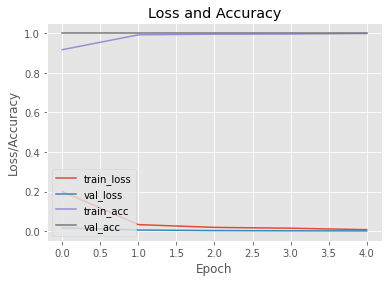

In [12]:
# plot
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), M.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), M.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), M.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), M.history["val_accuracy"], label="val_acc")
plt.title("Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])